US Arrests PCA and clustering 

Import modules

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Load dataset

In [28]:
df = pd.read_csv('UsArrests.csv')

df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


See statistics of data

In [29]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Plot histograms of key features

array([[<AxesSubplot:title={'center':'Murder'}>,
        <AxesSubplot:title={'center':'Assault'}>],
       [<AxesSubplot:title={'center':'UrbanPop'}>,
        <AxesSubplot:title={'center':'Rape'}>]], dtype=object)

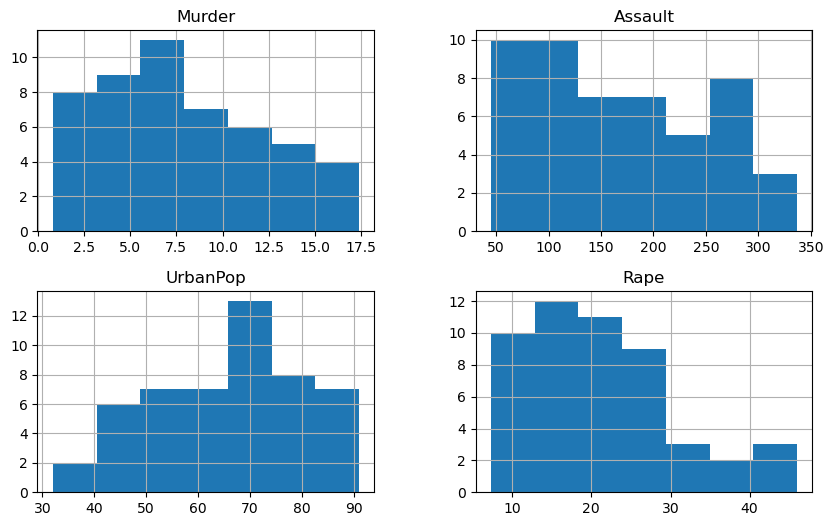

In [31]:
df.hist(figsize=(10,6), bins=7)

- Murder and assault distributions are more loosely uniform distributions. 
- Rape is a more irregular distribution. Most cities have 0-30 cases. 
- For assault there is an outlier between 250-300 cases, with 8 cities in this category. 
- Urban population has a skewed right histogram, with most cities having populations over 6 000 000 people. 

Check for missing data 

In [33]:
df.isnull().sum()

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

Set city name as index

In [34]:
df = df.set_index('City')

Create a correlation heat map of the data

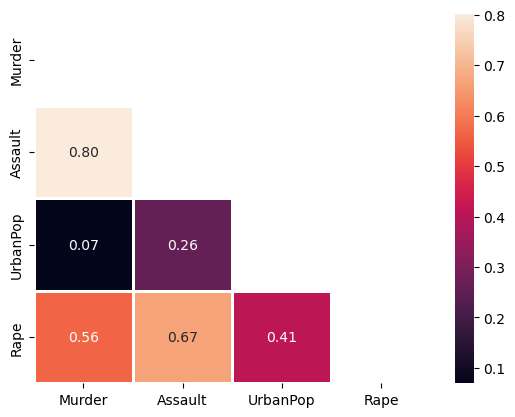

In [36]:
# Correlate unstandardised data
corr = df.corr()

#Removes half of the heat map that is repeated
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

# Generate Heat Map
ax = sns.heatmap(corr, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

plt.show()

- There are positive correlations between all of the variables. 
- There is the strongest positive correlation between murder and assault. 
- There is a positive (but weaker than between murder and assault) correlation between rape and murder, and assault and rape. 
- There is a very weak, almost negligible relationship between murder and city population. 
- The relationship is more positive between population and assault but still a weak correlation.
- There is a positive relationship between rape and population. 

Plot clusters using complete linkage

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Assault')

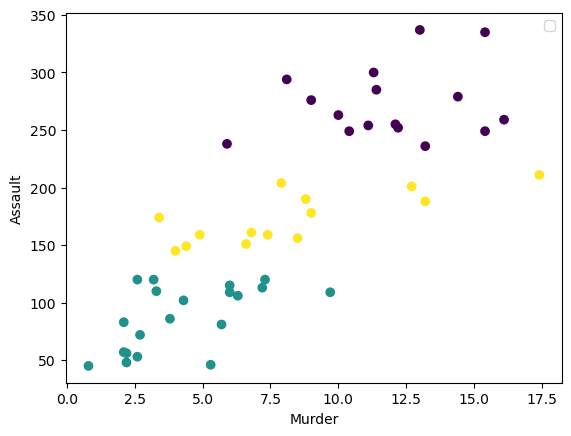

In [38]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
cluster.fit_predict(df)
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_)

plt.legend()
plt.xlabel('Murder')
plt.ylabel('Assault')

- From this it can be seen that there are three distinct city groups. Each with increased levels of violent crime.
- Cities with higher levels of assault also have higher levels of murder. 
- This only gives us relationship data between murder and assault and the grouping associated with them. PCA will be applied to the data to analyse the remainder of the dataset.

Principal Component Analysis
Unstandardised Data

In [50]:
k = 2
pca_unstandardised = PCA(n_components=k)
prin_components = pca_unstandardised.fit_transform(df)

unstandardised_df = pd.DataFrame(prin_components, index=df.index)

unstandardised_df.head()

,0,1
City,,
Alabama,64.802164,11.448007
Alaska,92.827450,17.982943
Arizona,124.068216,-8.830403
Arkansas,18.340035,16.703911
California,107.422953,-22.520070


Generate biplot of unstandardised PCA data

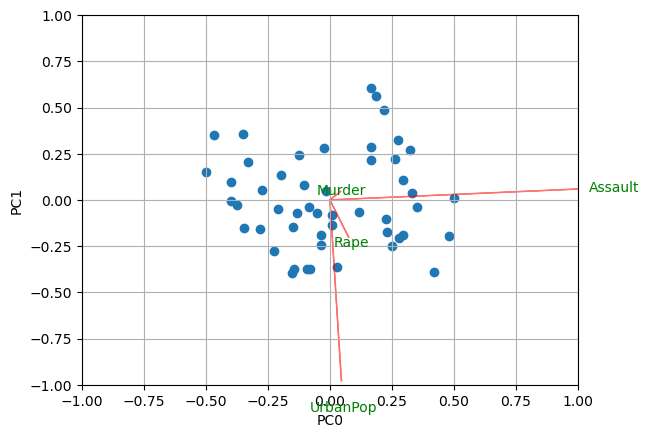

In [55]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex, ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(0))
    plt.ylabel("PC{}".format(1))
    plt.grid()

myplot(prin_components[:,0:2],np.transpose(pca_unstandardised.components_[0:2, :]))
plt.show()

- Assault and murder have a high relation to PC0 
- Urban population is likely to be related to PC1
- Rape is related to PC1, this is unexpected as it would be predicted that it would have a higher relation with the other crimes. The data will be standardised to determine if this is solved. 

Standardised Data

In [56]:
X = StandardScaler().fit_transform(df.values)

nr_comps = 2
model = PCA(n_components=0.85)

prin_components = model.fit_transform(X)

pca_df = pd.DataFrame(prin_components, index=df.index)

pca_df.head()

,0,1
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


Create a biplot of the standardised PCA data 

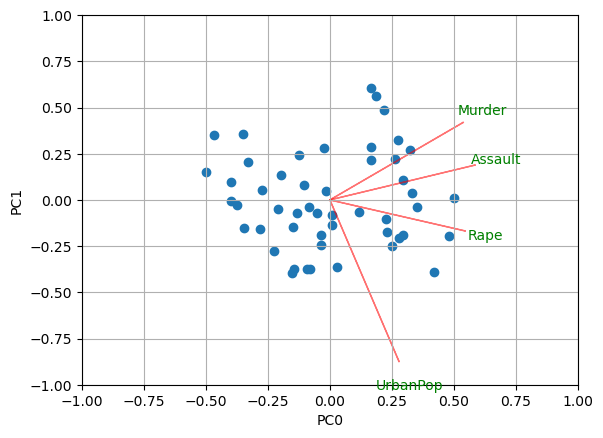

In [57]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(0))
    plt.ylabel("PC{}".format(1))
    plt.grid()

myplot(prin_components[:,0:2],np.transpose(model.components_[0:2, :]))
plt.show()

- PC0 is related to the crime statistics (rape, murder, assault)
- PC1 is related to the urban population
- The standardisation has improved the PCA data and it now makes more sense with what we already know about the correlations within the dataset. 
- States which have large positive scores in the PC0 dimension have a high overall crime rate. 
- Generally, states with a large PC1 score have a lower population (PC0) score. 
- There is a weak positive correlation between population and crime. 

Cluster Analysis 

Define X as the shaped standardised PCA data

In [59]:
X = pca_df.values.reshape(-1,2)

Average linkage

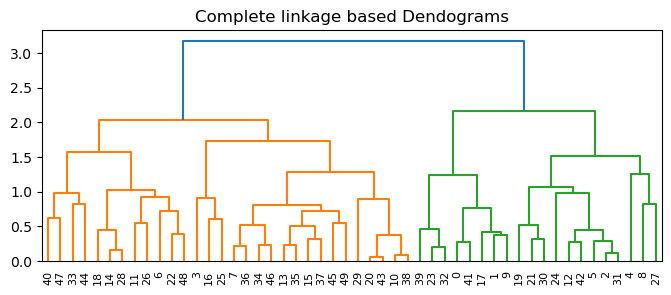

In [62]:
plt.figure(figsize=(8, 3))
plt.title("Complete linkage based Dendograms")  
dend = dendrogram(linkage(X, method='average')) 

Single linkage

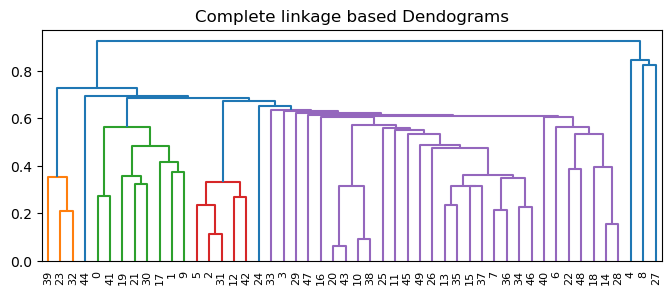

In [24]:
plt.figure(figsize=(8, 3))
plt.title("Complete linkage based Dendograms")  
dend = dendrogram(linkage(X, method='single')) 

Complete linkage

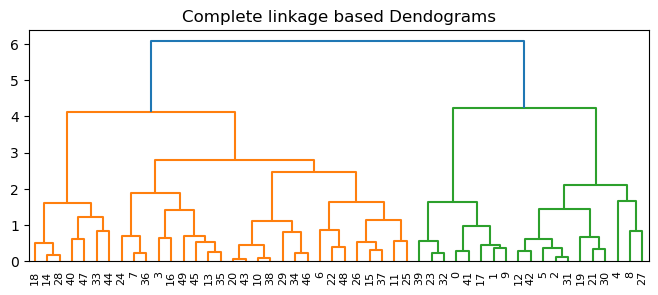

In [63]:
plt.figure(figsize=(8, 3))
plt.title("Complete linkage based Dendograms")  
dend = dendrogram(linkage(X, method='complete')) 

- The hierchical clustering using the complete method splits the PCA data best, into 4 distinct groups if taken at the level L=3. 
- The complete method with k=4 splits the data into 4 groups consisting of 8, 21, 11, and 8 points respectively.
- The low crime, high population group is the largest group with 21 points.

Agglomerative clustering, 4 clusters, complete linkage, euclidean affinity

Text(0, 0.5, 'PC1')

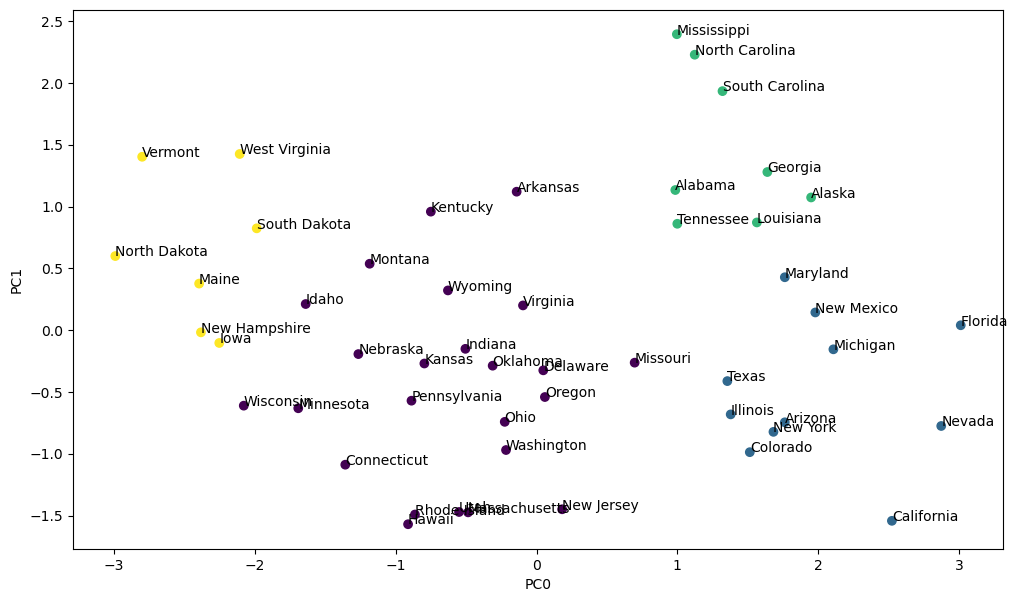

In [64]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit_predict(pca_df)
fig, ax = plt.subplots(figsize=(12, 7))
plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], c=cluster.labels_)

for x, y in pca_df.iterrows():
   ax.annotate(x, y)
plt.xlabel('PC0')
plt.ylabel('PC1')

- 4 clusters here can be seen
- Blue - high population and high crime (Smallest group)
- Yellow - low population and low crime
- Green - low population and high crime (Smallest group)
- Purple - high population and low crime (largest group)

K-Means analysis 

Text(0, 0.5, 'PC1')

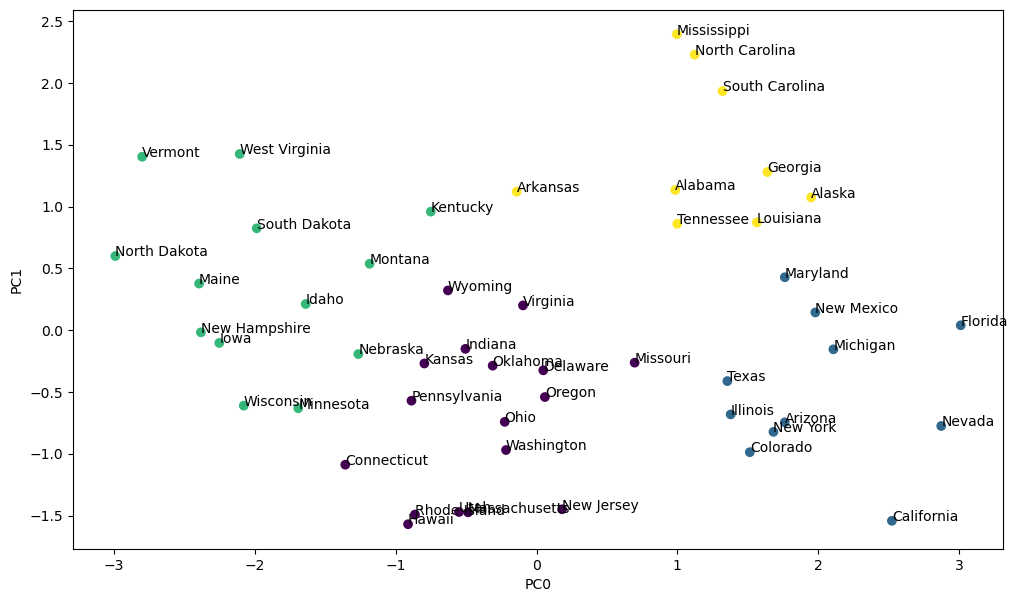

In [65]:
x = pca_df.values

kmeans = KMeans(n_clusters=4, random_state=4)
y_pred = kmeans.fit_predict(x)

fig, ax = plt.subplots(figsize=(12, 7))
plt.scatter(pca_df[0], pca_df[1], c=y_pred)

for x, y in pca_df.iterrows():
   ax.annotate(x, y)
plt.xlabel('PC0')
plt.ylabel('PC1')

- The clusters that were generated from agglomerative hierchical clustering are similar to those generated by the K-means model. 
- Blue - high population and high crime (Smallest group)
- Green - low population and low crime
- Yellow - low population and high crime (Smallest group)
- Purple - high population and low crime (largest group)
- The high population/low crime group (purple) is smaller from K-means, with Idaho, Kentucky, Montana, Nebraska, Minesota, and Wisconsin now considered to be part of the low population / low crime group
- Arkansas is now considered among the low population / high crime group
- The distribution between clusters is distinct in both models 
